# AT&T Spam Detector

## Librairies & Settings

In [22]:
# Import Tensorflow & Pathlib librairies
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, GlobalAveragePooling1D, GRU, SimpleRNN, LSTM
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

import pathlib 
import os
import io
import json
import warnings

from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

import spacy # for text encoding
from spacy.lang.en.stop_words import STOP_WORDS

#python -m spacy download en_core_web_sm
nlp = spacy.load('en_core_web_md')

warnings.filterwarnings('ignore')


# Dataset loading

In [23]:
df = pd.read_csv('data/spam.csv',encoding='ANSI')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


# 🔍 EDA - Exploratory Data Analysis 🔎

In [24]:
df.describe()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""","MK17 92H. 450Ppw 16""","GNT:-)"""
freq,4825,30,3,2,2


In [25]:
df = df.iloc[:, :2]
display(df.head())
display(df.describe())
display(df.shape)

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


,v1,v2
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


(5572, 2)

So we have ham that represent good messages and we have spam that represent undesired messages.

In [26]:
# 1 will represent ham and 0 spam
df["target"] = df["v1"].apply(lambda x : 1 if x == "spam" else 0)

As we can see below, we don't have a balanced representation. So we will need to fixe this with some weight in our model.

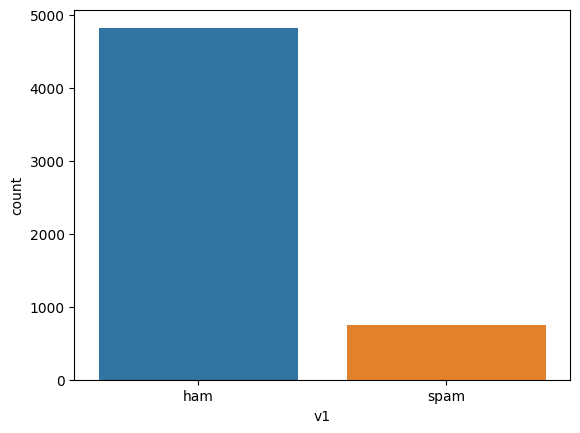

In [27]:
sns.countplot(data=df,x='v1')
plt.show()

# 2. Preprocessing

### 2.1 Text formating

On nettoie un peut notre text, en enlevant les caractères spéciaux, les espaces en trop, et les majuscules.

In [28]:
df["v2_cleaned"] = df["v2"].apply(lambda x : ''.join(ch for ch in x if ch.isalnum() or ch==" "))
df["v2_cleaned"] = df["v2_cleaned"].apply(lambda x: x.replace("  "," ").lower().strip())
df.head()

,v1,v2,target,v2_cleaned
0,ham,"Go until jurong point, crazy.. Available only ...",0,go until jurong point crazy available only in ...
1,ham,Ok lar... Joking wif u oni...,0,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,free entry in 2 a wkly comp to win fa cup fina...
3,ham,U dun say so early hor... U c already then say...,0,u dun say so early hor u c already then say
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,nah i dont think he goes to usf he lives aroun...


### 2.2 Lemnatization

In [29]:
# Lemmatisation grâce à spacy, adapté au vocabulaire "web", de taille medium :
df["v2_lemnatized"] = df["v2_cleaned"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) & (token.text not in STOP_WORDS)]))
df.head()

,v1,v2,target,v2_cleaned,v2_lemnatized
0,ham,"Go until jurong point, crazy.. Available only ...",0,go until jurong point crazy available only in ...,jurong point crazy available bugis n great wor...
1,ham,Ok lar... Joking wif u oni...,0,ok lar joking wif u oni,ok lar joke wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,free entry in 2 a wkly comp to win fa cup fina...,free entry 2 wkly comp win fa cup final tkts 2...
3,ham,U dun say so early hor... U c already then say...,0,u dun say so early hor u c already then say,u dun early hor u c
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,nah i dont think he goes to usf he lives aroun...,nah think usf live


### 2.3 Tokenization

In [30]:
token = tf.keras.preprocessing.text.Tokenizer()
token.fit_on_texts(df["v2_lemnatized"])
df["v2_tokenized"] = token.texts_to_sequences(df["v2_lemnatized"])
df.head()

,v1,v2,target,v2_cleaned,v2_lemnatized,v2_tokenized
0,ham,"Go until jurong point, crazy.. Available only ...",0,go until jurong point crazy available only in ...,jurong point crazy available bugis n great wor...,"[3626, 229, 443, 460, 941, 35, 50, 203, 942, 7..."
1,ham,Ok lar... Joking wif u oni...,0,ok lar joking wif u oni,ok lar joke wif u oni,"[9, 193, 461, 289, 1, 1453]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,free entry in 2 a wkly comp to win fa cup fina...,free entry 2 wkly comp win fa cup final tkts 2...,"[12, 299, 3, 531, 661, 33, 1454, 845, 419, 145..."
3,ham,U dun say so early hor... U c already then say...,0,u dun say so early hor u c already then say,u dun early hor u c,"[1, 124, 149, 2371, 1, 83]"
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,nah i dont think he goes to usf he lives aroun...,nah think usf live,"[704, 22, 662, 130]"


In [31]:
df["v2_len"] = df["v2_tokenized"].apply(lambda x: len(x))

# remove empty text
df = df[df["v2_len"]!=0]
display(df.head())
df.shape

,v1,v2,target,v2_cleaned,v2_lemnatized,v2_tokenized,v2_len
0,ham,"Go until jurong point, crazy.. Available only ...",0,go until jurong point crazy available only in ...,jurong point crazy available bugis n great wor...,"[3626, 229, 443, 460, 941, 35, 50, 203, 942, 7...",14
1,ham,Ok lar... Joking wif u oni...,0,ok lar joking wif u oni,ok lar joke wif u oni,"[9, 193, 461, 289, 1, 1453]",6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,free entry in 2 a wkly comp to win fa cup fina...,free entry 2 wkly comp win fa cup final tkts 2...,"[12, 299, 3, 531, 661, 33, 1454, 845, 419, 145...",22
3,ham,U dun say so early hor... U c already then say...,0,u dun say so early hor u c already then say,u dun early hor u c,"[1, 124, 149, 2371, 1, 83]",6
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,nah i dont think he goes to usf he lives aroun...,nah think usf live,"[704, 22, 662, 130]",4


(5555, 7)

In [32]:
# Par défaut le pading se fait sur la séquence la plus longue
train_pad = tf.keras.preprocessing.sequence.pad_sequences(df["v2_tokenized"], padding="post")
train_pad.shape

(5555, 72)

### 2.4 Splitting into train val and test sets

In [33]:
xtrain, xval, ytrain, yval = train_test_split(train_pad, df["target"],
                                              test_size=0.3, random_state=0,
                                              stratify=df["target"])

train = tf.data.Dataset.from_tensor_slices((xtrain, ytrain))
val = tf.data.Dataset.from_tensor_slices((xval, yval))

train_data = train.shuffle(len(train)).batch(64)
val_data = val.shuffle(len(val)).batch(64)

Pour chaque target on affiche à côté la séquence que l'on a crée

In [34]:
for text_batch, label_batch in train_data.take(1):
  for i in range(5):
    print(label_batch[i].numpy(), text_batch.numpy()[i])

0 [ 913   15    3   93  891   24 1669  485 1045   36 1669  485    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]
0 [ 593 2080    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]
0 [   6  939 2355  303  557 7625    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0  

# 3. Modeling

In [35]:
embedding_dim=16 # the dimensionality of the representation space
vocab_size = len(token.word_counts) # # Vocabulary size and number of words in a sequence.
display(vocab_size)

8218

In [36]:
# global average embedding
model_GAP = Sequential([
  Embedding(vocab_size+1, embedding_dim, name="embedding"), 
  GlobalAveragePooling1D(),
  Dense(32, activation='relu'),
  Dense(16, activation='relu'),
  Dense(2, activation="sigmoid") # we are in binary classification case, so it's seems a good choice
])

model_GAP.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          131504    
                                                                 
 global_average_pooling1d_1   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_3 (Dense)             (None, 32)                544       
                                                                 
 dense_4 (Dense)             (None, 16)                528       
                                                                 
 dense_5 (Dense)             (None, 2)                 34        
                                                                 
Total params: 132,610
Trainable params: 132,610
Non-trainable params: 0
________________________________________________

In [37]:
# model compilation
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0008)
model_GAP.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [38]:
# model fitting

# get the apparition frequency for spam
spam_freq = pd.DataFrame(df["target"].value_counts())
spam_freq.sort_index(inplace=True)
class_weight = {v: (1 / spam_freq.loc[v,"target"]) / 2 * spam_freq["target"].sum() for v in spam_freq.index}

model_GAP.fit(
    train_data,
    validation_data=val_data,
    class_weight=class_weight,
    epochs=30)

Epoch 1/30
61/61 [==============================] - 2s 12ms/step - loss: 0.6910 - sparse_categorical_accuracy: 0.8655 - val_loss: 0.6653 - val_sparse_categorical_accuracy: 0.8656
Epoch 2/30
61/61 [==============================] - 0s 5ms/step - loss: 0.6812 - sparse_categorical_accuracy: 0.8812 - val_loss: 0.6292 - val_sparse_categorical_accuracy: 0.8764
Epoch 3/30
61/61 [==============================] - 0s 4ms/step - loss: 0.6313 - sparse_categorical_accuracy: 0.9162 - val_loss: 0.5042 - val_sparse_categorical_accuracy: 0.9382
Epoch 4/30
61/61 [==============================] - 0s 6ms/step - loss: 0.4930 - sparse_categorical_accuracy: 0.9624 - val_loss: 0.2875 - val_sparse_categorical_accuracy: 0.9604
Epoch 5/30
61/61 [==============================] - 0s 7ms/step - loss: 0.3051 - sparse_categorical_accuracy: 0.9817 - val_loss: 0.1909 - val_sparse_categorical_accuracy: 0.9760
Epoch 6/30
61/61 [==============================] - 0s 5ms/step - loss: 0.1694 - sparse_categorical_accuracy:

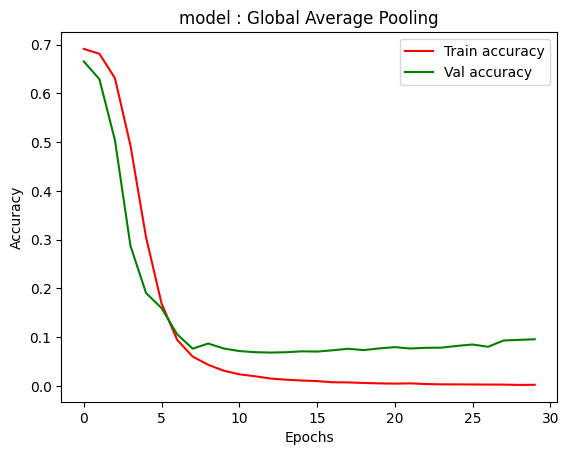

In [39]:
# plot model
# Visualization of the training process on the loss function 
plt.plot(model_GAP.history.history["loss"], color="r", label = "Train accuracy")
plt.plot(model_GAP.history.history["val_loss"], color="g", label='Val accuracy')
plt.gca().set(title='Loss',xlabel='Epochs',ylabel='Accuracy')
plt.title("model : Global Average Pooling")
plt.legend()
plt.show()

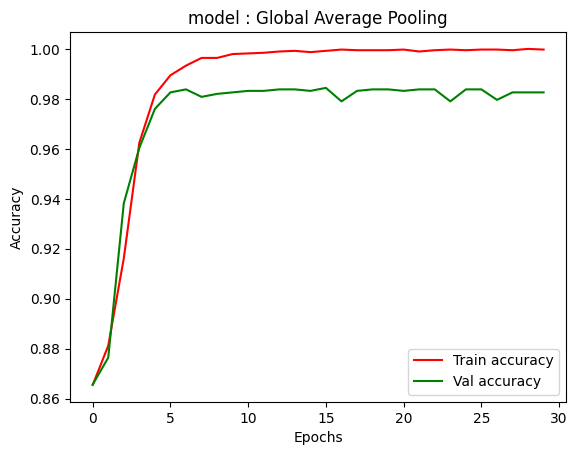

In [40]:
plt.plot(model_GAP.history.history["sparse_categorical_accuracy"], color="r", label='Train accuracy')
plt.plot(model_GAP.history.history["val_sparse_categorical_accuracy"], color="g", label='Val accuracy')
plt.gca().set(title='Accuracy',xlabel='Epochs',ylabel='Accuracy')
plt.title("model : Global Average Pooling")
plt.legend()
plt.show()

The model need only some epochs to acheive a good performance, and start being stable after epoch 5th

Let's do some predictions

53/53 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1443
           1       0.99      0.88      0.93       224

    accuracy                           0.98      1667
   macro avg       0.99      0.94      0.96      1667
weighted avg       0.98      0.98      0.98      1667



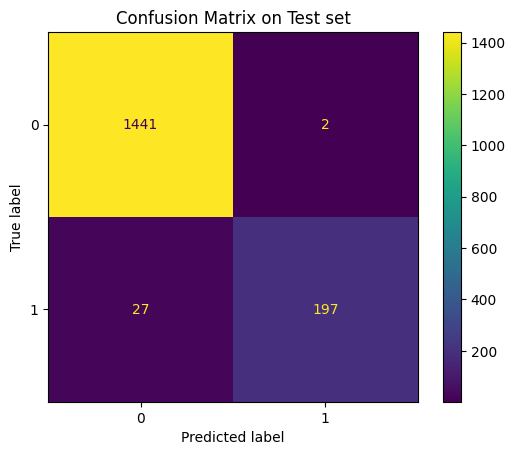

In [41]:
yp_val = model_GAP.predict(xval)
print(classification_report(yval, yp_val.argmax(axis=1)))
# plot
_ , ax = plt.subplots()
ax.set(title="Confusion Matrix on Test set")
ConfusionMatrixDisplay.from_predictions(yval, yp_val.argmax(axis=1), ax=ax)
plt.show()

The model failed only 27 times to identify a spam (out of 224) and fail 2 times by identifying a ham as spam (out of 1443 instances).
The performance is good, but we have to be sure that the sms will be kept inside spam box and not destroyed XD

In [42]:
# saving model
# https://www.tensorflow.org/api_docs/python/tf/keras/Sequential
# save format : Either 'tf' or 'h5'. A filepath ending in '.h5' or '.keras' will default to HDF5 if save_format is None. Otherwise None defaults to 'tf'.
model_GAP.save("models/model_GAP.h5")